# Server-Side Code

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from IPython.display import display, HTML
from PIL import Image
from scipy.stats import pearsonr
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model

### Neighbor Search

In [2]:
# Data paths
data_dir = "../polyvore_outfits/"
images_path = data_dir + "images/"

# Load in embeddings
embeddings_path = data_dir + "embeddings.npy"
embeddings = np.load(embeddings_path)

# Load in filenames
filenames_path = data_dir + "filenames.txt"
filenames_file = open(filenames_path, 'r')
filenames = [line.strip() for line in filenames_file.readlines()]

# Error checking for embeddings + filenames
if len(embeddings) != len(filenames):
    print("STOP. The lengths of embeddings and filenames don't match")
    print(len(embeddings), len(filenames))

# Create nearest neighbor search for embeddings
neighbors = NearestNeighbors(n_neighbors=6, algorithm='brute', metric='euclidean')
neighbors.fit(embeddings)


NearestNeighbors(algorithm='brute', metric='euclidean', n_neighbors=6)

In [3]:
# Load in outfits metadata
outfits_metadata_path = data_dir + "outfits_metadata.json"
outfits_file = open(outfits_metadata_path, 'r')
outfit_map = json.load(outfits_file)

# Load in item (clothing) metadata
item_metadata_path = data_dir + "item_metadata.json"
items_file = open(item_metadata_path, 'r')
items_map = json.load(items_file)

# Inverted index from image to boards they are part of
item_to_outfits = {}
for outfit_id, metadata in outfit_map.items():
    for item in metadata['items']:
        item_id = item['item_id']
        item_to_outfits[item_id] = item_to_outfits.get(item_id, []) + [outfit_id]
        

### Inference Model

In [4]:
# Half of the Inference Model Stored on Server Side
class ServerResnet(tf.keras.Model):
    def __init__(self, *args, **kwargs):
        super(ServerResnet, self).__init__(*args, **kwargs)
        
        # Load ResNet50 pre-trained model without top (fully connected) layers
        resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        resnet_base.trainable = False
        
        # Get the output of the last two convolutional layer before Pooling
        middle_layer = resnet_base.get_layer('conv3_block4_out')
        last_conv_layer = resnet_base.get_layer('conv5_block3_out')

        self.seq1 = tf.keras.Sequential([
            Model(inputs=middle_layer.output, outputs=last_conv_layer.output),
            tf.keras.layers.GlobalMaxPooling2D(),
        ])

    # Forward pass of the server model
    def call(self, inputs):
        server_embeddings = self.seq1(inputs)

        # Normalize data
        flatten_result = tf.keras.layers.Flatten()(server_embeddings)
        result_normalized = flatten_result / tf.norm(flatten_result)
        return result_normalized[0]

ServerModel = ServerResnet()

In [7]:
# Replace: This is a mimic for recieving from client
client_embeddings = np.load("client_embeddings.npy")
server_embeddings = ServerModel.call(client_embeddings)

noise_embeddings = np.load("noise_embeddings.npy")
server_embeddings2 = ServerModel.call(noise_embeddings)

cluster_embeddings = np.load("cluster_embeddings.npy")
server_embeddings3 = ServerModel.call(cluster_embeddings)

print(pearsonr(server_embeddings, server_embeddings2))
print(pearsonr(server_embeddings, server_embeddings3))

# Metrics just to see number of parameters
ServerModel.build((1, 28, 28, 512))
ServerModel.summary()

PearsonRResult(statistic=0.927106649264801, pvalue=0.0)
PearsonRResult(statistic=0.9858900706202895, pvalue=0.0)
Model: "server_resnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 2048)              22127616  
                                                                 
Total params: 22,127,616
Trainable params: 0
Non-trainable params: 22,127,616
_________________________________________________________________


### Display Results

In [70]:
def displayBoard(key):
    # Size hyperparameters
    num_items = len(outfit_map[key]['items'])
    image_width = 300

    # Loop through image items
    concatenated_image = np.zeros((image_width, 0, 3), dtype=np.uint8)
    item_descriptions = []
    for ids in outfit_map[key]['items']:
        path = "../polyvore_outfits/images/" + ids['item_id'] + ".jpg"
        image = Image.open(path)

        image = image.resize((image_width, image_width), Image.LANCZOS)
        image_array = np.array(image)
        concatenated_image = np.concatenate((concatenated_image, image_array), axis=1)

        description = items_map[ids['item_id']]['url_name'] + " (" + items_map[ids['item_id']]['semantic_category'] + ")"
        item_descriptions.append(description)

    # Display board
    plt.figure(figsize=(image_width * num_items / 100, image_width / 100))  # Adjusted figure size
    plt.imshow(concatenated_image)
    plt.axis('off')

    plt.show()

def display_items(distance, indices):
    html_string, boards, matched_ids = "", [], []

    # Display similar items
    for file_idx in indices[0]:
        # Load in images
        filename = filenames[file_idx]
        img_tag = f"<img src='{images_path + filename}' style='width:{100}px;height:{100}px;margin:0;padding:0;'>"
        html_string += img_tag

        # Get boards for associated images
        img_path = filenames[file_idx][:-4]
        img_board = item_to_outfits.get(img_path, [])
        boards.extend(img_board)
        matched_ids.extend([filename[:-4] for i in range(len(img_board))])

    return boards, html_string, matched_ids

def aggregate_board(board_id, matched_item_id):
    descriptions = []
    concatenated_image = np.zeros((256, 0, 3), dtype=np.uint8)

    # Loop through items and collect descriptions + images
    for item in outfit_map[board_id]['items']:
        item_id = item["item_id"]

        # Add description and semantic category
        description = items_map[item_id]["url_name"]
        description += " (" + items_map[item_id]['semantic_category'] + ")"
        descriptions.append(description)

        # Get the image
        image = Image.open(images_path + item_id + ".jpg")

        # Resize
        image = np.array(image.resize((256, 256), Image.LANCZOS))
        image_array = np.array(image)

        if item_id == matched_item_id:
            continue
        
        concatenated_image = np.concatenate((concatenated_image, image_array), axis=1)

    return descriptions, concatenated_image

In [71]:
distance, indices = neighbors.kneighbors([server_embeddings])
board_ids, html_string, matched_ids = display_items(distance, indices)
display(HTML(html_string))

distance, indices = neighbors.kneighbors([server_embeddings2])
board_ids, html_string, matched_ids = display_items(distance, indices)
display(HTML(html_string))

distance, indices = neighbors.kneighbors([server_embeddings3])
board_ids, html_string, matched_ids = display_items(distance, indices)
display(HTML(html_string))

# Display similar boards
# for board in board_ids:
#     displayBoard(board)

['marni suede shoulder bag (bags)', 'suede ankle boots (shoes)', 'chicnova fashion fringe detail embroidery (tops)', 'dondup denim shirt (tops)', 'abercrombie fitch one teaspoon awesome (bottoms)']


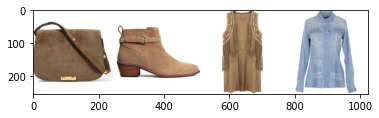

['aeropostale triangle embroidery backpack (bags)', 'camel color block mesh panel (shoes)', 'pearl bangle bracelet ring pack (jewellery)', 'white pineapple embroidery shirt with (tops)', 'abercrombie fitch one teaspoon awesome (bottoms)', 'khaki butterflies embroidery bomber jacket (outerwear)']


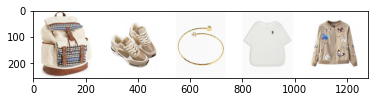

['dolce gabbana banana leaf-print leather (bags)', 'michael kors daisy loafers (shoes)', 'striped bell sleeve tee (tops)', 'casual denim bleach wash shorts (bottoms)', 'bleach wash jeans jacket (outerwear)']


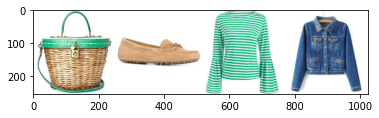

['yoins grey shoulder bag removable (bags)', 'yoins grey suede-look pointed toe (shoes)', 'yoins leaf print round neck (tops)', 'mango contrast mom straight jeans (bottoms)']


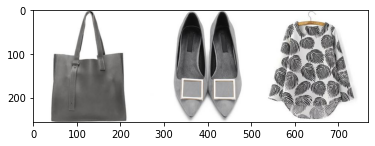

In [74]:
# Information to be forwarded to client
for i, board_id in enumerate(board_ids):
    descriptions, board_img = aggregate_board(board_id, matched_ids[i])
    print(descriptions)
    plt.imshow(board_img)
    plt.show()

### Sensitivy Metrics

In [82]:
import glob

def compute_sensitivity(model, input_data):
    with tf.GradientTape() as tape:
        tape.watch(input_data)
        output = model(input_data)
    
    # Compute gradients of the output with respect to the input data
    gradients = tape.gradient(output, input_data)
    
    # Compute the norm of the gradients
    sensitivity = tf.norm(gradients, ord=2)
    
    return sensitivity

folder_path = "../polyvore_outfits/noise_embeddings"
npy_files = glob.glob(folder_path + "/*.npy")

# Initialize an empty list to store the loaded data
data_list = []
for npy_file in npy_files:
    data = tf.convert_to_tensor(np.load(npy_file))
    data_list.append(data)

sensitivities = []
for point in data_list:
    sensitivities.append(compute_sensitivity(ServerModel, point))

overall_sensitivity = tf.reduce_max(sensitivities)
overall_sensitivity

<tf.Tensor: shape=(), dtype=float32, numpy=3.277522>